In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate -U

In [1]:
import numpy as np
import pandas as pd
import os

from datasets import load_dataset, DatasetDict, concatenate_datasets

import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

import matplotlib.pyplot as plt

In [ ]:
%cd /content/drive/MyDrive

In [2]:
INPUT_DIR = "./"
OUTPUT_DIR = "./output/xlm-roberta"
CHECKPOINT = "symanto/xlm-roberta-base-snli-mnli-anli-xnli"
CACHE_DIR = "./models"

In [3]:
# Load data
data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "train.csv"), trust_remote_code=True, split="train")

data = data.train_test_split(0.2)

translated_data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "translated.csv"), trust_remote_code=True, split="train")

train_data = concatenate_datasets([data['train'], translated_data])
train_data = train_data.shuffle(seed=42)

data = DatasetDict(
    {
        "train": train_data,
        "val": data["test"],
        "test": load_dataset("csv", data_files=os.path.join(INPUT_DIR, "test.csv"), trust_remote_code=True, split="train"),
    }
)
data



# # Load data
# data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "train.csv"), trust_remote_code=True, split="train")
# data = data.train_test_split(0.2)

# data = DatasetDict(
#     {
#         "train": data["train"],
#         "val": data["test"],
#         "test": load_dataset("csv", data_files=os.path.join(INPUT_DIR, "test.csv"), trust_remote_code=True, split="train"),
#     }
# )

# data

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 105876
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 5195
    })
})

In [ ]:
df = data["train"].to_pandas()
df.head()

In [ ]:
df[["premise", "hypothesis", "lang_abv", "language"]].describe()

In [ ]:
df[["lang_abv", "language"]].value_counts()

In [ ]:
df.isna().sum()

In [4]:
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT, truncation=True, cache_dir=CACHE_DIR)
model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=3, cache_dir=CACHE_DIR)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN3Cls(nn.Module):
    def __init__(self):
        super(CNN3Cls, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=768, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=768, out_channels=512, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # x = torch.unsqueeze(x, 1)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        x = x.mean(dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# class CNNCls(nn.Module):
#     def __init__(self):
#         super(CNNCls, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.2)
#         self.fc = nn.Linear(256, 3)

#     def forward(self, x):
#         x = x.permute(0, 2, 1)
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = x.permute(0, 2, 1)
#         x = x.mean(dim=1)
#         x = self.dropout(x)
#         x = self.fc(x)
#         return x

class LSTMCls(nn.Module):
    def __init__(self):
        super(LSTMCls, self).__init__()
        self.lstm = nn.LSTM(input_size=768, hidden_size=256, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # LSTM返回两个元组，(output, (h_n, c_n))
        # output: (batch_size, seq_length, num_directions * hidden_size)
        # h_n: (num_layers * num_directions, batch_size, hidden_size)
        # c_n: (num_layers * num_directions, batch_size, hidden_size)
        output, (h_n, c_n) = self.lstm(x)
        x = self.relu(output[:, -1, :])  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x

class GRUCls(nn.Module):
    def __init__(self):
        super(GRUCls, self).__init__()
        self.gru = nn.GRU(input_size=768, hidden_size=256, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # GRU的输出 (output, h_n)
        output, h_n = self.gru(x)  # output: (batch_size, seq_length, hidden_size)
        x = self.relu(output[:, -1, :])  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x

class RNNCls(nn.Module):
    def __init__(self):
        super(RNNCls, self).__init__()
        self.rnn = nn.RNN(
            input_size=768, hidden_size=256, num_layers=1, batch_first=True
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        output, h_n = self.rnn(x) 
        x = output[:, -1, :]
        x = self.relu(x) 
        x = self.dropout(x)
        x = self.fc(x)
        return x

class MultiheadAttentionCls(nn.Module):
    def __init__(self):
        super(MultiheadAttentionCls, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(768, 3)

    def forward(self, x):
        # 假设x的形状是(batch_size, seq_length, embed_dim)
        # 多头注意力需要输入key, query, value，这里我们使用同一个x作为三者
        attn_output, _ = self.attention(x, x, x)
        # 取多头注意力输出的平均或者最后一个时间步的输出
        x = self.relu(attn_output.mean(dim=1))
        x = self.dropout(x)
        x = self.fc(x)
        return x

# model.classifier = CNN3Cls()


model



/usr/local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/921 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [5]:
def preprocess_data(batch):
    return tokenizer(batch['premise'], batch['hypothesis'], truncation=True, padding=True)


data = data.map(preprocess_data, batched=True)
data

Map:   0%|          | 0/105876 [00:00<?, ? examples/s]

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'input_ids', 'attention_mask'],
        num_rows: 105876
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'input_ids', 'attention_mask'],
        num_rows: 5195
    })
})

In [6]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=labels)

train_args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, "results"),
    logging_dir=os.path.join(OUTPUT_DIR, "logs"),
    report_to=[],
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    save_steps=200,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.005,
    num_train_epochs=1,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=3,
    save_only_model=True,
)

# train_args = TrainingArguments(
#     output_dir=os.path.join(OUTPUT_DIR, "results"),
#     logging_dir=os.path.join(OUTPUT_DIR, "logs"),
#     report_to=[],
#     evaluation_strategy="steps",
#     eval_steps=200,
#     logging_steps=200,
#     save_steps=200,
#     per_device_eval_batch_size=16,
#     per_device_train_batch_size=16,
#     learning_rate=2e-5,
#     weight_decay=0.005,
#     num_train_epochs=5,
#     fp16=True,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     save_total_limit=3,
#     save_only_model=True,
# )

train_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'gradient_accumulation_kwargs': None},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_steps=200,
evaluation_strategy=steps,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_

In [7]:
trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=data["train"],
    eval_dataset=data["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# trainer = Trainer(
#     model=model,
#     args=train_args,
#     data_collator=data_collator,
#     train_dataset=data["train"],
#     eval_dataset=data["val"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     callbacks=[EarlyStoppingCallback(3)],
# )

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
200,0.665000,0.358140,0.882013
400,0.584500,0.353087,0.874175
600,0.560300,0.325561,0.880363
800,0.559400,0.306230,0.889439
1000,0.558400,0.320001,0.884901
1200,0.541900,0.285692,0.896865
1400,0.519600,0.277933,0.901815
1600,0.486400,0.289938,0.889026
1800,0.493300,0.255500,0.914191
2000,0.476900,0.236986,0.915017


TrainOutput(global_step=6618, training_loss=0.41344237327575684, metrics={'train_runtime': 809.436, 'train_samples_per_second': 130.802, 'train_steps_per_second': 8.176, 'total_flos': 1.6506124258571136e+16, 'train_loss': 0.41344237327575684, 'epoch': 1.0})

In [8]:
log = trainer.state.log_history
log

[{'loss': 0.665,
  'grad_norm': 25.101661682128906,
  'learning_rate': 1.940767603505591e-05,
  'epoch': 0.030220610456331218,
  'step': 200},
 {'eval_loss': 0.35814040899276733,
  'eval_accuracy': 0.8820132013201321,
  'eval_runtime': 3.9617,
  'eval_samples_per_second': 611.851,
  'eval_steps_per_second': 38.367,
  'epoch': 0.030220610456331218,
  'step': 200},
 {'loss': 0.5845,
  'grad_norm': 23.358074188232422,
  'learning_rate': 1.8803263825929286e-05,
  'epoch': 0.060441220912662436,
  'step': 400},
 {'eval_loss': 0.35308679938316345,
  'eval_accuracy': 0.8741749174917491,
  'eval_runtime': 3.9405,
  'eval_samples_per_second': 615.152,
  'eval_steps_per_second': 38.574,
  'epoch': 0.060441220912662436,
  'step': 400},
 {'loss': 0.5603,
  'grad_norm': 18.269580841064453,
  'learning_rate': 1.8198851616802662e-05,
  'epoch': 0.09066183136899365,
  'step': 600},
 {'eval_loss': 0.3255605697631836,
  'eval_accuracy': 0.8803630363036303,
  'eval_runtime': 4.0031,
  'eval_samples_per_se

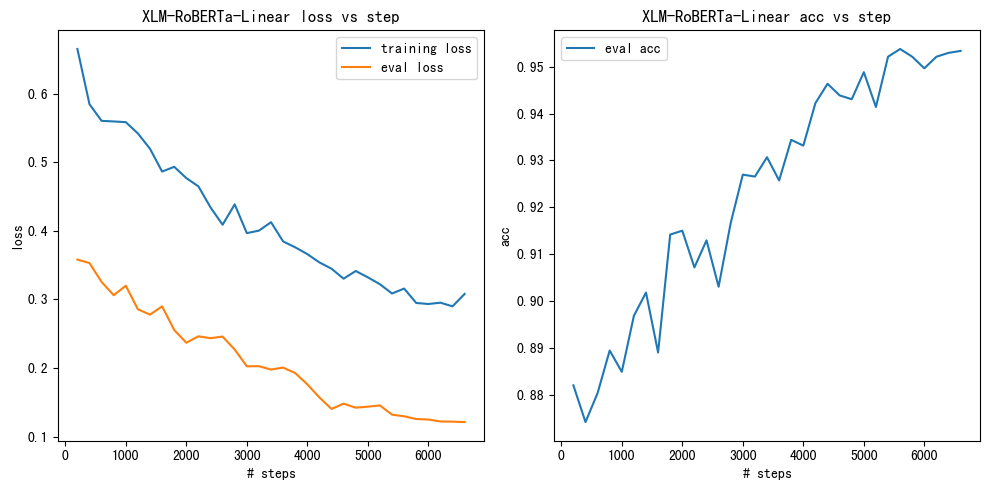

In [9]:
steps = []
train_loss = []
eval_loss = []
eval_acc = []

for i in range(0, len(log) - 1, 2):
    train_log = log[i]
    eval_log = log[i + 1]
    steps.append(train_log["step"])
    train_loss.append(train_log["loss"])
    eval_loss.append(eval_log["eval_loss"])
    eval_acc.append(eval_log["eval_accuracy"])

plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.title("XLM-RoBERTa-Linear loss vs step")
plt.xlabel("# steps")
plt.ylabel("loss")
plt.plot(steps, train_loss, label="training loss")
plt.plot(steps, eval_loss, label="eval loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("XLM-RoBERTa-Linear acc vs step")
plt.xlabel("# steps")
plt.ylabel("acc")
plt.plot(steps, eval_acc, label="eval acc")
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
import json

with open("XLM-RoBERTa-Linear_aug.json", "w") as f:
    json.dump(
        {
            "steps": steps,
            "train_loss": train_loss,
            "eval_loss": eval_loss,
            "eval_acc": eval_acc,
        },
        f,
        indent=4,
    )

In [11]:
preds = trainer.predict(data["test"])
preds

PredictionOutput(predictions=array([[-2.4980469 , -2.8046875 ,  5.46875   ],
       [-3.4296875 ,  4.6835938 , -1.7685547 ],
       [ 3.5       , -0.71728516, -1.8359375 ],
       ...,
       [ 4.8164062 , -2.6132812 , -0.89453125],
       [ 5.15625   , -2.6699219 , -1.1289062 ],
       [-2.7070312 , -1.7792969 ,  4.5546875 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 3.9426, 'test_samples_per_second': 1317.672, 'test_steps_per_second': 82.434})

In [ ]:
pd.DataFrame(
    {"id": data["test"]["id"], "prediction": np.argmax(preds.predictions, axis=1)}
).to_csv(os.path.join(OUTPUT_DIR, "submission.csv"), header=True, index=False)